# Import Libraries

In [287]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2

from tensorflow import keras
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from skimage.transform import resize
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.utils import resample

from PIL import Image

# ! pip install visualkeras
import visualkeras
import os

import warnings
warnings.filterwarnings('ignore')

In [324]:
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report

# Loading Dataset

In [57]:
dir = '/kaggle/input'
label = []
path = []
for dirname, _,filenames in os.walk(dir):
    for filename in filenames:
        label.append(os.path.split(dirname)[1])
        path.append(os.path.join(dirname,filename))
             
df = pd.DataFrame(columns=['Image','Label'])
df['Image']=path
df['Label']=label

df = shuffle(df)
df = df.reset_index(drop=True)

### Observing Dataset

In [58]:
len(df)

11525

In [59]:
df.head()

,Image,Label
0,/kaggle/input/eyes-rtte/maleeyes/7421.jpg,maleeyes
1,/kaggle/input/eyes-rtte/maleeyes/3836.jpg,maleeyes
2,/kaggle/input/eyes-rtte/femaleeyes/1544.jpg,femaleeyes
3,/kaggle/input/eyes-rtte/maleeyes/274.jpg,maleeyes
4,/kaggle/input/eyes-rtte/maleeyes/6437.jpg,maleeyes


In [60]:
df.tail()

,Image,Label
11520,/kaggle/input/eyes-rtte/maleeyes/5436.jpg,maleeyes
11521,/kaggle/input/eyes-rtte/maleeyes/498.jpg,maleeyes
11522,/kaggle/input/eyes-rtte/femaleeyes/3562.jpg,femaleeyes
11523,/kaggle/input/eyes-rtte/maleeyes/1542.jpg,maleeyes
11524,/kaggle/input/eyes-rtte/maleeyes/1295.jpg,maleeyes


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11525 entries, 0 to 11524
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   11525 non-null  object
 1   Label   11525 non-null  object
dtypes: object(2)
memory usage: 180.2+ KB


In [62]:
# check total count and frequency of each label
df.describe()

,Image,Label
count,11525,11525
unique,11525,2
top,/kaggle/input/eyes-rtte/maleeyes/7421.jpg,maleeyes
freq,1,6323


There are total of 11525 Images in the entire dataset, having 2 labels [maleeyes, femaleeyes]. Frequency of maleeyes is greater then frequency of female eyes.

In [63]:
# check for null values or missing labels
df.isna().sum()

Image    0
Label    0
dtype: int64

No null entries present in dataset.

In [64]:
# check for duplicate entries
df.duplicated().any()

False

There are no duplicate entries present in the dataset

maleeyes      6323
femaleeyes    5202
Name: Label, dtype: int64


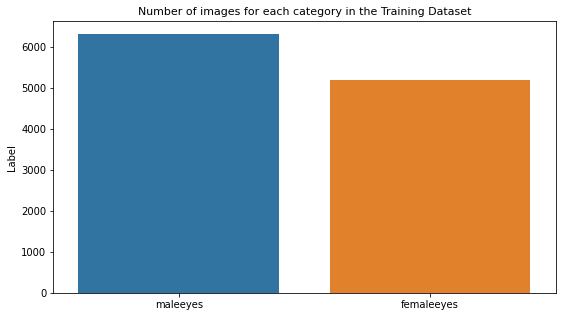

In [65]:
vc = df['Label'].value_counts()
print(vc)
plt.figure(figsize = (9, 5))
sns.barplot(x = vc.index, y = vc)
plt.title("Number of images for each category in the Training Dataset", fontsize = 11)
plt.show()

The dataset has 6323 images of male and 5202 images of female eyes

#### Balancing Dataset

In [66]:
# Using downsampling to balance the dataset, 
# as there is not a big difference in the total number of samples in both categories

# Dividing majority and minority classes
df_major = df[df.Label=='maleeyes']
df_minor = df[df.Label=='femaleeyes']

df_major_sample = resample(df_major,
               replace=False,  # Down sample without replacement
               n_samples=5202,   # Number to match minority class
               random_state=42)
  
# Combine both samples
df = pd.concat([df_major_sample, df_minor])
df = shuffle(df)
df = df.reset_index(drop=True)

# Display count of data points in both class
print(df.Label.value_counts())

df.describe()

maleeyes      5202
femaleeyes    5202
Name: Label, dtype: int64


,Image,Label
count,10404,10404
unique,10404,2
top,/kaggle/input/eyes-rtte/maleeyes/3460.jpg,maleeyes
freq,1,5202


Using the downsampling technique we removed extra samples from maleeyes, now both labels have 5202 samples having all unique values. 

### Observing the images

Here we can see that size of both images are not same, hence we will resize female images to 54x54

In [67]:
xx = df[df['Label'] == 'femaleeyes'].index[0]
xy = df[df['Label'] == 'maleeyes'].index[0]

Text(0.5, 1.0, 'femaleeyes')

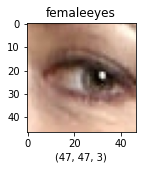

In [68]:
# visualize female eye
figure = plt.figure(figsize=(2,2))
x = plt.imread(df["Image"][xx])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(df["Label"][xx])

Text(0.5, 1.0, 'maleeyes')

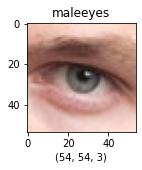

In [69]:
# visualize male eye
figure = plt.figure(figsize=(2, 2))
x = plt.imread(df["Image"][xy])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(df["Label"][xy])

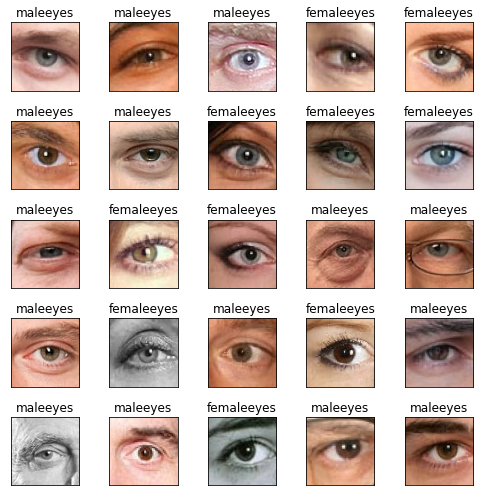

In [70]:
# plot more random images from dataset
fig, axes = plt.subplots(nrows = 5,
                        ncols = 5,
                        figsize = (7, 7),
                        subplot_kw = {"xticks":[],"yticks":[]})

for i,ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df["Image"][i]))
    ax.set_title(df["Label"][i])
plt.tight_layout()
plt.show()

In [71]:
# Checking image size
female_eye_size = plt.imread(df["Image"][xx])
print(female_eye_size.shape, '==>',  df['Label'][xx])

male_eye_size = plt.imread(df["Image"][xy])
print(male_eye_size.shape, '==>',  df['Label'][xy])

(47, 47, 3) ==> femaleeyes
(54, 54, 3) ==> maleeyes


Here all the images have varying sizes, we should resize all the images to equal size for better classification.

In [105]:
# Check how many different sized images are there

size_list=set() # empty set for checking total different sizes of images

for x in range(len(df['Image'])):
    size_list.add(plt.imread(df["Image"][x]).shape)

print(len(size_list))
print('Smallest size :', list(sorted(size_list))[0])
print('Largest size :', list(sorted(size_list))[-1])

65
Smallest size : (41, 41, 3)
Largest size : (117, 117, 3)


The dataset contains images with 65 different sizes, ranging from 41x41 to 117x117.
We will now resize them to 64x64 size.

In [240]:
# Convert image path to array of image using cv2
size = (64,64)
df1 = df.copy()

size_list = set()
for i in range(len(df)):
    image=cv2.imread(df['Image'][i])
    image=cv2.resize(image,size)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    size_list.add(image.shape)
    df1['Image'][i] = image.flatten()

In [241]:
# Check shape after resizing
size_list

{(64, 64, 3)}

Now all the images have same size ==> 64x64, and falttened to perform KNN

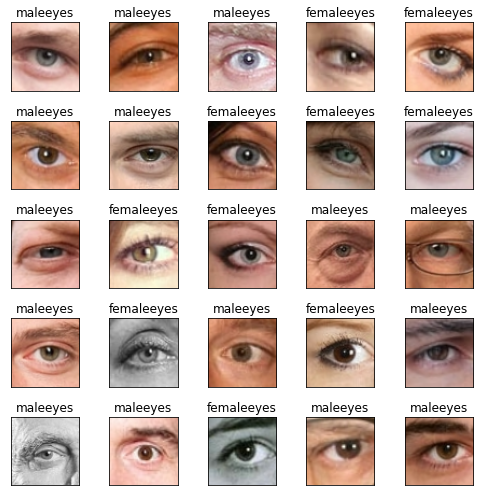

In [250]:
# Finally let's see some random images again

fig, axes = plt.subplots(nrows = 5,
                        ncols = 5,
                        figsize = (7, 7),
                        subplot_kw = {"xticks":[],"yticks":[]})

for i,ax in enumerate(axes.flat):
    ax.imshow(df1.Image[i].reshape(64,64,3))
    ax.set_title(df1["Label"][i])
plt.tight_layout()
plt.show()

In [253]:
# Convert labels to numeric values

LE = LabelEncoder()

df1['Label'] = np.asarray(LE.fit_transform(df1["Label"]))

display(df1.head())

,Image,Label
0,"[246, 195, 178, 247, 196, 179, 246, 195, 180, ...",1
1,"[195, 137, 99, 196, 138, 100, 198, 139, 104, 1...",1
2,"[203, 156, 150, 207, 162, 156, 205, 160, 155, ...",1
3,"[185, 143, 119, 175, 133, 109, 167, 125, 100, ...",0
4,"[255, 193, 154, 254, 192, 153, 254, 191, 154, ...",0


# KNN

In [304]:
# Split data into train and test

X_train, X_test,y_train, y_test = train_test_split(df1.Image, df1.Label, test_size = 0.2, random_state = 7)

X_train = np.vstack(X_train.reset_index(drop=True))
X_test = np.vstack(X_test.reset_index(drop=True))
y_train = np.vstack(y_train.reset_index(drop=True))
y_test = np.vstack(y_test.reset_index(drop=True))

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)


(8323, 12288) (2081, 12288)
(8323, 1) (2081, 1)


In [ ]:
# Applying KNN multiple times to find best value of K

error_rate = []

for i in range(1,50):
 
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

In [ ]:
# Elbow plot to see optimum value of K
plt.figure(figsize=(10,6))
plt.plot(range(1,50),error_rate,color=’blue’, linestyle=’dashed’, marker=’o’, markerfacecolor=’red’, markersize=10)
plt.title(‘Error Rate vs. K Value’)
plt.xlabel(‘K’)
plt.ylabel(‘Error Rate’)

In [ ]:
# NOW WITH K=
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)

In [321]:
# Print accuracy
%time
# 82.5
print('KNN Accuracy: %.3f' % accuracy_score(y_test,pred))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 10.7 µs
KNN Accuracy: 0.838


In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test,pred)
plt.figure(figsize=(9,9))
sns.heatmap(cm,annot=True, fmt='.3f', linewidths=.5, square=True,cmap="Pastel1")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test,pred))
plt.title(all_sample_title,size=15)

In [326]:
# Classification report
classification_report(y_test,pred)

              precision    recall  f1-score   support

           0       0.90      0.76      0.82      1026
           1       0.80      0.91      0.85      1055

    accuracy                           0.84      2081
   macro avg       0.85      0.84      0.84      2081
weighted avg       0.85      0.84      0.84      2081

